# Wie zitieren sich Höchstgerichte untereinander?

In [1]:
#imports
import pandas as pd
from bs4 import BeautifulSoup
import re
import graphviz
import unicodedata
import calendar
import time
from matplotlib import pyplot as plt
import itertools 


# 1. (Test-)Datensätze laden oder generieren

Zur Beantwortung der Frage, müssen gerichtliche Entscheidungen analysiert werden.
Zunächst müssen die Entscheidungen daher aus dem RIS ermittelt werden.

Um das RIS nicht immer bemühen zu müssen, wurden Entscheidungen in Dateien zwischengespeichert

# 1.1 Read created Test-Data

In [2]:
#Read Data from github
#Cerate dictionary for easier data handling
dataframes={}
for organ in ["OGH","VwGH","VfGH"]:
     #print(organ)
     dataframes[organ] = pd.read_pickle("https://github.com/michael-l-AT/test-data/raw/main/"+organ+"E.pkl")


In [41]:
#Read locally stored testdata (due to githubs filesize limit)

#Cerate dictionary for easier data handling
dataframes={}
for organ in ["OGH","VwGH","VfGH"]:
     #print(organ)
     dataframes[organ] = pd.read_pickle(organ+"_2020_2021.pkl")


In [63]:
#testcode to reduce dataset for easier testing
for organ in ["OGH","VwGH","VfGH"]:
     #print(organ)
     dataframes[organ] = dataframes[organ].truncate(after=99)

## 1.2 Create Test-Data

Es werden alle Entscheidungen der Jahre 2020 und 2021 herunterleladen und zwischengespeichert

In [19]:
#get text of decisions - mind the sleeptime (nice value to reduce load on RIS)

def get_html(document_url,sleeptime:int=5):
    #print(xml_url)
    r_volltext=requests.get(document_url).content
    soup=BeautifulSoup(r_volltext,"lxml").find('div', class_='documentContent').text
    soup=unicodedata.normalize("NFKD", soup)
    time.sleep(sleeptime)  # time to wait in order to reduce requests on RIS
    return(soup)

In [25]:
#Get decisions by month - due to "nice" value (check "time.sleep" in get_html) this will tage ages

for organ in ["OGH","VwGH","VfGH"]:
    for year in [2020,2021]:
        #print(year)
        for month in ["01","02","03","04","05","06","07","08","09","10","11","12"]:
            date_from=str(year)+"-"+month+"-01"
            date_to=str(str(year)+"-"+month+"-"+str(calendar.monthrange(int(year), int(month))[1]))
            
            print(f"Getting decisions from {date_from} to {date_to}")
            if organ == "OGH":
                E=Justiz(court="OGH",show_rechtssaetze=False,decision_date_from=date_from,decision_date_to=date_to)
            
            if organ == "VwGH":
                E=Vwgh(show_rechtssaetze=False,decision_date_from=date_from,decision_date_to=date_to)
            
            if organ == "VfGH":
                E=Vfgh(show_rechtssaetze=False,decision_date_from=date_from,decision_date_to=date_to)

            
            df = pd.DataFrame(E._results)
            if len(df): # store dataframe only if decicions were found 
                df['case_number']= df['case_number'].apply(lambda x: str(x[0]) )
                df['Volltext']=df.apply(lambda x: get_html(x['document_url']), axis=1)
                df_.to_pickle(organ+"_"+str(year)+"_"+str(month)+".pkl")



Getting decisions from 2021-04-01 to 2021-04-30
Getting decisions from 2021-05-01 to 2021-05-31
Getting decisions from 2021-06-01 to 2021-06-30
Getting decisions from 2021-07-01 to 2021-07-31
Getting decisions from 2021-08-01 to 2021-08-31
Getting decisions from 2021-09-01 to 2021-09-30
Getting decisions from 2021-10-01 to 2021-10-31
Getting decisions from 2021-11-01 to 2021-11-30
Getting decisions from 2021-12-01 to 2021-12-31


In [249]:
#Concat decisions

dataframes={}
for organ in ["OGH","VwGH","VfGH"]:
    decisions = []
    for year in [2020,2021]:
        #print(year)

        for month in ["01","02","03","04","05","06","07","08","09","10","11","12"]:
            try:
                decisions.append(pd.read_pickle(organ+"_"+str(year)+"_"+str(month)+".pkl"))
            #print(decisions)
            except FileNotFoundError:
                print("No decitions in this month")
            except Exception as e:
                print(repr(e))
                raise Exception("Exception")

    
    #print(decisions)
    dataframes[organ] = pd.concat(decisions, ignore_index=True)
    dataframes[organ].to_pickle(organ+"_2020_2021.pkl")
        
        


No decitions in this month
No decitions in this month
No decitions in this month
No decitions in this month
No decitions in this month
No decitions in this month
No decitions in this month


### 1.2.1 OGH

Alternativ können Entscheidungen auch anhand bestimmter Parameter ausgewählt werden

In [75]:
# Alternatively get decisions by parameters (eg. date - see RIS-API-Wraper for parameters)
OGH_E=Justiz(court="OGH",show_rechtssaetze=False,decision_date_from="2021-10-20")

In [77]:
df_OGH = pd.DataFrame(OGH_E._results)
df_OGH['case_number']= df_OGH['case_number'].apply(lambda x: str(x[0]) ) # convert to string for easier handling

In [ ]:
df_OGH['Volltext']=df_OGH.apply(lambda x: get_html(x['document_url']), axis=1)
dataframes["OGH"]=df_OGH

In [ ]:
display(dataframes["OGH"])

### 1.2.2 VfGH

In [23]:
#get decisions by date
VfGH_E=Vfgh(show_rechtssaetze=False,decision_date_from="2021-04-28")

In [27]:
df_VfGH = pd.DataFrame(VfGH_E._results)
df_VfGH['case_number']= df_VfGH['case_number'].apply(lambda x: str(x[0]) )

In [28]:
df_VfGH['Volltext']=df_VfGH.apply(lambda x: get_html(x['document_url']), axis=1)
dataframes["VfGH"]=df_VfGH

In [ ]:
display(dataframes["VfGH"])

### 1.2.3 VwGH

In [68]:
#get decisions by date
VwGH_E=Vwgh(show_rechtssaetze=False,decision_date_from="2021-10-15")

In [71]:
df_VwGH = pd.DataFrame(VwGH_E._results)
df_VwGH['case_number']= df_VwGH['case_number'].apply(lambda x: str(x[0]) )

In [72]:
df_VwGH['Volltext']=df_VwGH.apply(lambda x: get_html(x['document_url']), axis=1)
dataframes["VwGH"]=df_VwGH

In [ ]:
display(dataframes["VwGH"])

# 2. Auffinden zitierter Entscheidungen (regex-Patterns)

Innerhalb von Entscheidungen sollen zitierte Entscheidungen aufgefunden werden. Die Erstellung eines möglichst passenden regex-Musters stellte die größte Herausforderung dar.

Wahrscheinlich können alle regex-Muster verbessert / optimiert werden.

Um die Anzahl von fälschlicherweise erkannten Zitierungen zu verhindern, könnte eine Gegenprüfung durch das RIS angestellt werden. Nur Entscheidungen, die sich auch im RIS auffinden lassen, könnten als (valide) Zitierungen erachtet werden. Zur Entlastung der RIS-API wurde dieser Schritt aber nicht durchgeführt.

In [43]:
#find cited decisions
def find_citings (case_number:str,text:str,organ:str):
  #print(case_number)
  citings =set() # use a set to only list unique citings
  citings.clear()
  pattern=""
  if organ =="OGH":
    #§ 40 OGH-Geo 2019 (1) Das Aktenzeichen besteht aus der Senatszahl, dem Gattungszeichen, der Aktenzahl, den beiden letzten Ziffern des Anfalljahrs sowie in den IT-gestützt geführten Registerfällen aus einem Prüfzeichen, zB: 3 Ob 127/19i; 1 Nc 20/17p; 11 Os 93/19k.
    pattern='([0-9]{1,3} ?(O|D|P|D|N|G|F|E|R)[A-Za-zäöü]{1,3} ?([0-9]{1,3})\/[0-9]{2}[a-z])' #needs to be improved
  if organ =="VfGH":
    pattern='(((E|A|UA|G|WI|V|SV|KI) ?[0-9]{1,4}\/[0-9]{4})(?![a-z])( ua)?)' # needs to be improved (lots of false positives - decisions prior 2000 are not found)

  if organ =="VfGH_Slg":
    pattern='((?:(?<=VfSlg\. )|(?<=VfSlg )).{1,7}(?=\/\d{4}))'  

  if organ =="VwGH":
    pattern='(((R[a|o] ?)|(Fr ?))[0-9]{1,4}/[0-9]{2}/[0-9]{4})' # needs to be improved
    
  if organ =="VwGH_Slg":
    pattern='(VwSlg\.? .{1,8}\/\d{4})'
    
  #print(text)
  
  
  for m in re.finditer(pattern,text): # ! Regex is not correct needs to be redefined
    #print(m.group(0))
    citings.add(replace_GZ(m,organ))
  
  citings.discard(case_number) #remove self "citings"
    
  #one could add a check, if all citings are found in RIS here - not done in order to reduce load on RIS-API  

  #print(citings)
  return citings






In [44]:
# Helper Function to transform case_numbers to format used in RIS
def replace_GZ(m,organ):
  ris_gz=m.group(0)
  #print(m.group(0))
  if (organ != "VwGH" and organ != "VwGH_Slg"): # VwGH has spaces in case_numbers
    ris_gz=m.group(0).replace(" ", "")
  if (organ =="VfGH"):
    ris_gz=m.group(0).removesuffix('ua')
  return ris_gz

In [45]:
def add_citings(dataframe):
    #print(dataframe)
    for cited_organ in ["OGH","VfGH","VfGH_Slg","VwGH","VwGH_Slg"]:
        dataframe[cited_organ+'_citings']=dataframe.apply(lambda x: find_citings(x['case_number'],x['Volltext'],cited_organ), axis=1)
    

In [46]:
for organ_dataframe in dataframes.values():
    add_citings(organ_dataframe)

Um das Zitierverhalten von Gerichten weiter zu analysieren, kann analysiert werden, welche Entscheidungen die zitierten Entscheidungen zitieren. 

In [30]:
#function to recursively find cited decisions in originally cited decisions
def find_citings_recursive (organ:str,cited_organ:str,case_numbers:set,num_calls:int=0,sleeptime:int=5):
  if isinstance(case_numbers,set) and len(case_numbers)>0:
    for case_number in case_numbers:
        
        #print(case_number)
        if not case_number in dataframes[cited_organ]["case_number"].values: # if decision was already checked, skip it
            if cited_organ=="OGH":
                result = None
                result=Justiz(court="OGH",show_rechtssaetze=False,case_number=case_number)
            if cited_organ=="VwGH":
                result = None
                result=Vwgh(show_rechtssaetze=False,case_number=case_number)
            if cited_organ=="VfGH":
                result = None
                result=Vfgh(show_rechtssaetze=False,case_number=case_number)
            
            
            try: # test if the decision text can be fetched 
                if result._results[0]['document_url']:
                    volltext=get_html(result._results[0]['document_url'],sleeptime)
                    citings=find_citings (case_number,volltext,cited_organ)
                    print(f'checking: {case_number} - found: {citings}') # output to keep the user informed
                    cited_colum=cited_organ+"_citings"
                    
                    
                    #according to forum-posts adding rows to dataframe is a bad idea
                    # this could be reworked to use lists insted and combine them
                    
                    new_row={'case_number': case_number, cited_colum: citings, 'Volltext': volltext,'document_url':result._results[0]['document_url']}
                    dataframes[cited_organ] = dataframes[cited_organ].append(new_row, ignore_index = True)
                    
                    
                    # save as pickle to be able to resume if programm crashes - or takes to long
                    dataframes[cited_organ].to_pickle(cited_organ+"_recursive.pkl") 
                    
                    
                    if num_calls == 0:
                        continue
                    find_citings_recursive(organ,cited_organ,citings,num_calls-1)
                    
            except IndexError:
                #if response does not contain Key(s) for any reason also return nothing 
                print("Decision not found:",case_number)
                continue # with next case_number
            except Exception as e:
                print(repr(e))
                raise Exception("Exception")
              


  else: # no decisions were cited
    return("")

In [34]:
#find citings recursively - set number of "recursions"
for organ in ["OGH","VwGH","VfGH"]:
    for cited_organ in ["OGH","VwGH","VfGH"]:
        restult=[find_citings_recursive(organ,cited_organ,case_numbers,0,1) for case_numbers in dataframes[organ][cited_organ+'_citings']] #set number of revisions to a higher number to look even "deeper"

checking: 8Nc39/03g - found: {'2Nc18/03z', '6Nc15/03p', '10Nc10/03g', '4Nc14/03a', '3Nc13/03x', '5Nc14/03h', '7Nc13/03a'}
checking: 9Nc48/19m - found: {'2Nc27/17v', '5Nc13/18h'}
checking: 2Ob164/17g - found: {'2Ob8/05y', '5Ob227/11k', '2Ob255/01s', '2Ob233/06p', '2Ob48/14v', '2Ob167/10p', '2Ob218/17y', '2Ob206/09x', '7Ob117/15d', '4Ob204/13y', '2Ob150/06g', '2Ob62/13a', '2Ob71/16d', '6Ob185/09p', '2Ob38/02f', '2Ob213/08z', '2Ob83/06d', '2Ob205/08y', '9Ob50/17v', '2Ob36/15f'}
checking: 7Ob145/13v - found: {'7Ob108/11z', '7Ob144/99y', '7Ob189/12p', '4Ob125/12d', '7Ob69/13t'}
checking: 8Ob55/12i - found: {'8ObA22/02x', '1Ob291/00a'}
checking: 7Ob133/14f - found: {'7Ob212/11v', '7Ob144/99y', '4Ob57/11b', '3Ob305/02h', '3Ob136/13s', '7Ob215/11k', '5Ob269/06v'}
checking: 10Ob21/18p - found: {'6Ob79/99g', '9ObA61/15h', '3Ob203/14w', '1Ob85/05i', '8ObA104/01d', '9ObA61/17m', '7Ob101/12x', '7Ob56/08y', '3Ob172/15p'}
checking: 2Ob233/08s - found: {'2Ob40/08t', '1Ob144/02m'}
checking: 6Ob1/03w - 

In [12]:
for organ_dataframe in dataframes.values():
    display(organ_dataframe)

,type,rechtssatz_number,case_number,european_case_law_identifier,judicial_body,decision_date,published,edited,legal_norms,document_url,content_urls,Volltext,OGH_citings,VfGH_citings,VfGH_Slg_citings,VwGH_Slg_citings,VwGH_citings
0,Entscheidungstext,None,8Nc3/20p,[ECLI:AT:OGH0002:2020:0080NC00003.20P.0131.000],OGH,2020-01-31,2020-04-03,2020-04-03,None,https://www.ris.bka.gv.at/Dokument.wxe?Abfrage...,"[{'Name': 'Hauptdokument', 'Datatype': 'Xml', ...",\n\n\r\n Begleitende Dokumente\r\n \n\n\r\...,"{8Nc39/03g, 9Nc48/19m}",{},{},{},{}
1,Entscheidungstext,None,2Ob4/20g,[ECLI:AT:OGH0002:2020:0020OB00004.20G.0130.000],OGH,2020-01-30,2020-03-04,2020-03-04,None,https://www.ris.bka.gv.at/Dokument.wxe?Abfrage...,"[{'Name': 'Hauptdokument', 'Datatype': 'Xml', ...",\n\n\r\n Begleitende Dokumente\r\n \n\n\r\...,{2Ob164/17g},{},{},{},{}
2,Entscheidungstext,None,2Ob6/20a,[ECLI:AT:OGH0002:2020:0020OB00006.20A.0130.000],OGH,2020-01-30,2020-02-26,2021-07-29,None,https://www.ris.bka.gv.at/Dokument.wxe?Abfrage...,"[{'Name': 'Hauptdokument', 'Datatype': 'Xml', ...",\n\n\r\n Begleitende Dokumente\r\n \n\n\r\...,"{2Ob79/18h, 10Ob21/18p, 6Ob1/03w, 7Ob133/14f, ...",{},{},{},{}
3,Entscheidungstext,None,2Ob10/20i,[ECLI:AT:OGH0002:2020:0020OB00010.20I.0130.000],OGH,2020-01-30,2020-04-17,2020-04-17,None,https://www.ris.bka.gv.at/Dokument.wxe?Abfrage...,"[{'Name': 'Hauptdokument', 'Datatype': 'Xml', ...",\n\n\r\n Begleitende Dokumente\r\n \n\n\r\...,"{2Ob27/17k, 2Ob243/07k, 2Ob153/11f}",{},{},{},{}
4,Entscheidungstext,None,2Ob12/19g,[ECLI:AT:OGH0002:2020:0020OB00012.19G.0130.000],OGH,2020-01-30,2020-03-26,2021-11-08,None,https://www.ris.bka.gv.at/Dokument.wxe?Abfrage...,"[{'Name': 'Hauptdokument', 'Datatype': 'Xml', ...",\n\n\r\n Begleitende Dokumente\r\n \n\n\r\...,"{5Ob21/19b, 5Ob3/99y, 9Ob1/18i, 7Ob286/03i, 8O...",{},{},{},{}


,type,rechtssatz_number,case_number,european_case_law_identifier,judicial_body,decision_date,published,edited,legal_norms,document_url,content_urls,Volltext,OGH_citings,VfGH_citings,VfGH_Slg_citings,VwGH_Slg_citings,VwGH_citings
0,Entscheidungstext,None,Ra 2017/22/0108,[ECLI:AT:VWGH:2020:RA2017220108.L00],Verwaltungsgerichtshof (VwGH),2020-01-31,2020-02-27,2020-02-27,"[AVG §37, B-VG Art133 Abs4, NAG 2005 §64 Abs3 ...",https://www.ris.bka.gv.at/Dokument.wxe?Abfrage...,"[{'Name': 'Hauptdokument', 'Datatype': 'Xml', ...",\n\n\r\n Begleitende Dokumente\r\n \n\n\r\...,{},{},{},{},"{Ra 2019/22/0005, Ra 2018/22/0040, Ra 2017/22/..."
1,Entscheidungstext,None,Ra 2018/17/0220,[ECLI:AT:VWGH:2020:RA2018170220.L00],Verwaltungsgerichtshof (VwGH),2020-01-31,2020-04-23,2020-04-23,"[GSpG 1989 §56a Abs6, VwGG §33 Abs1, VwGG §55,...",https://www.ris.bka.gv.at/Dokument.wxe?Abfrage...,"[{'Name': 'Hauptdokument', 'Datatype': 'Xml', ...",\n\n\r\n Begleitende Dokumente\r\n \n\n\r\...,{},{},{},{},"{Ro 2015/17/0028, Ra 2016/17/0259, Ra 2017/17/..."
2,Entscheidungstext,None,Ra 2019/06/0277,[ECLI:AT:VWGH:2020:RA2019060277.L00],Verwaltungsgerichtshof (VwGH),2020-01-31,2020-03-05,2020-03-05,"[BauO Tir 2018 §34 Abs10, VwGG §30 Abs2]",https://www.ris.bka.gv.at/Dokument.wxe?Abfrage...,"[{'Name': 'Hauptdokument', 'Datatype': 'Xml', ...",\n\n\r\n Begleitende Dokumente\r\n \n\n\r\...,{},{},{},{},"{Ro 2018/06/0018, Ra 2017/07/0079}"
3,Entscheidungstext,None,Ra 2019/11/0046,[ECLI:AT:VWGH:2020:RA2019110046.L00],Verwaltungsgerichtshof (VwGH),2020-01-31,2020-03-10,2020-03-10,"[B-VG Art133 Abs4, FSG 1997 §23 Abs3, VwGG §28...",https://www.ris.bka.gv.at/Dokument.wxe?Abfrage...,"[{'Name': 'Hauptdokument', 'Datatype': 'Xml', ...",\n\n\r\n Begleitende Dokumente\r\n \n\n\r\...,{},{},{},{},"{Ra 2018/11/0103, Ra 2018/11/0198, Ra 2018/11/..."
4,Entscheidungstext,None,Ra 2019/17/0068,[ECLI:AT:VWGH:2020:RA2019170068.L00],Verwaltungsgerichtshof (VwGH),2020-01-31,2020-04-23,2020-04-23,"[GSpG 1989 §56a Abs6, VwGG §33 Abs1, VwGG §56,...",https://www.ris.bka.gv.at/Dokument.wxe?Abfrage...,"[{'Name': 'Hauptdokument', 'Datatype': 'Xml', ...",\n\n\r\n Begleitende Dokumente\r\n \n\n\r\...,{},{},{},{},"{Ro 2015/17/0028, Ra 2016/17/0259, Ra 2017/17/..."


,type,rechtssatz_number,case_number,european_case_law_identifier,judicial_body,decision_date,published,edited,legal_norms,document_url,content_urls,Volltext,OGH_citings,VfGH_citings,VfGH_Slg_citings,VwGH_Slg_citings,VwGH_citings
0,Entscheidungstext,None,E3875/2019 ua,[ECLI:AT:VFGH:2020:E3875.2019],Verfassungsgerichtshof (VfGH),2020-01-21,None,2020-02-25,"[BVG-Rassendiskriminierung ArtI Abs1, AsylG 20...",https://www.ris.bka.gv.at/Dokument.wxe?Abfrage...,"[{'Name': 'Hauptdokument', 'Datatype': 'Xml', ...",\n\n\r\n Begleitende Dokumente\r\n \n\n\r\...,{},{E3875/2019 },"{16.214, 14.393, 20.267, 14.650, 13.836, 15.45...",{},{}
1,Entscheidungstext,None,G276/2019,[ECLI:AT:VFGH:2020:G276.2019],Verfassungsgerichtshof (VfGH),2020-02-28,None,2020-06-09,"[B-VG Art140 Abs1 Z1 litd, B-VG Art140 Abs1 / ...",https://www.ris.bka.gv.at/Dokument.wxe?Abfrage...,"[{'Name': 'Hauptdokument', 'Datatype': 'Xml', ...",\n\n\r\n Begleitende Dokumente\r\n \n\n\r\...,{},"{G315/2015 , G252/2016, G201/2014, G640/2015 ,...","{14.342, 16.212, 19.746, 13.965, 15.964, 18.29...",{},{}
2,Entscheidungstext,None,G287/2019,[ECLI:AT:VFGH:2020:G287.2019],Verfassungsgerichtshof (VfGH),2020-02-28,None,2020-09-14,"[B-VG Art140 Abs1 Z1 litc, Grundrechtsbeschwer...",https://www.ris.bka.gv.at/Dokument.wxe?Abfrage...,"[{'Name': 'Hauptdokument', 'Datatype': 'Xml', ...",\n\n\r\n Begleitende Dokumente\r\n \n\n\r\...,{},"{G91/2018, G272/2018}","{15.786, 16.772, 11.803}",{},{}
3,Entscheidungstext,None,V81/2019,[ECLI:AT:VFGH:2020:V81.2019],Verfassungsgerichtshof (VfGH),2020-02-28,None,2020-06-08,"[B-VG Art139 Abs1 / Prüfungsgegenstand, B-VG A...",https://www.ris.bka.gv.at/Dokument.wxe?Abfrage...,"[{'Name': 'Hauptdokument', 'Datatype': 'Xml', ...",\n\n\r\n Begleitende Dokumente\r\n \n\n\r\...,{},"{G201/2014, G318/2018, V42/2013}","{16.365, 16.756, 16.618, 13.965, 11.868}",{},{}
4,Entscheidungstext,None,G3/2020,[ECLI:AT:VFGH:2020:G3.2020],Verfassungsgerichtshof (VfGH),2020-02-28,None,2020-06-12,"[B-VG Art144 Abs1 litc, Krnt ObjektivierungsG ...",https://www.ris.bka.gv.at/Dokument.wxe?Abfrage...,"[{'Name': 'Hauptdokument', 'Datatype': 'Xml', ...",\n\n\r\n Begleitende Dokumente\r\n \n\n\r\...,{},"{G78/2019 , G79/2013, G201/2014, G140/2014 , G...","{16.212, 20.111, 19.746, 16.756, 13.965, 11.86...",{},{}


# 3. Grafische Darstellung von Zitierungen

## 3.1 Grafische Darstellung mittels graphviz (dot)

Um einen raschen Überblick über Verbindungen zwischen Entscheidungen zu bekommen, wird ein dot-Diagramm erstellt.
Bei vielen Entscheidungen wird dies rasch unübersichtlich.

In [65]:
dot = graphviz.Digraph(engine='fdp') # try alternative engines if result does not suit (circo dot  fdp neato  osage   twopi)
#del dot # uncomment if you want to rew-create the graph

In [66]:
def create_graph(dataframe):
  #convert any NaN values to empty strings
  dataframe.fillna('', inplace=True) # make sure there are no NaN-Values in dataframe - otherwise more if statements would be needed
  for row in dataframe.itertuples():
    #print(df_OGH.loc[row.Index, 'case_number'])
    dot.node(dataframe.loc[row.Index, 'case_number'])
    #print(dataframe.loc[row.Index, 'VfGH_citings'])
    if (isinstance(dataframe.loc[row.Index, 'VfGH_citings'], set)):
      for citing in dataframe.loc[row.Index, 'VfGH_citings']:
        #print(citing)
        dot.edge(dataframe.loc[row.Index, 'case_number'], citing,color="red")
    if (dataframe.loc[row.Index, 'VfGH_Slg_citings']):
      for citing in dataframe.loc[row.Index, 'VfGH_Slg_citings']:
        #print(citing)
        dot.edge(dataframe.loc[row.Index, 'case_number'], citing,color="red")
    if (dataframe.loc[row.Index, 'OGH_citings']):
      for citing in dataframe.loc[row.Index, 'OGH_citings']:
        #print(citing)
        dot.edge(dataframe.loc[row.Index, 'case_number'], citing,color="green")
    if (dataframe.loc[row.Index, 'VwGH_citings']):
      for citing in dataframe.loc[row.Index, 'VwGH_citings']:
        #print(citing)
        dot.edge(dataframe.loc[row.Index, 'case_number'], citing,color="blue")
    if (dataframe.loc[row.Index, 'VwGH_Slg_citings']):
      for citing in dataframe.loc[row.Index, 'VwGH_Slg_citings']:
        #print(citing)
        dot.edge(dataframe.loc[row.Index, 'case_number'], citing,color="blue")

In [67]:
for organ_dataframe in dataframes.values():
    create_graph(organ_dataframe)

In [68]:
dot.source

'digraph {\n\t"8Nc3/20p"\n\t"8Nc3/20p" -> "8Nc39/03g" [color=green]\n\t"8Nc3/20p" -> "9Nc48/19m" [color=green]\n\t"2Ob4/20g"\n\t"2Ob4/20g" -> "2Ob164/17g" [color=green]\n\t"2Ob6/20a"\n\t"2Ob6/20a" -> "2Ob79/18h" [color=green]\n\t"2Ob6/20a" -> "10Ob21/18p" [color=green]\n\t"2Ob6/20a" -> "6Ob1/03w" [color=green]\n\t"2Ob6/20a" -> "7Ob133/14f" [color=green]\n\t"2Ob6/20a" -> "1Ob11/10i" [color=green]\n\t"2Ob6/20a" -> "8Ob55/12i" [color=green]\n\t"2Ob6/20a" -> "2Ob58/15s" [color=green]\n\t"2Ob6/20a" -> "7Ob91/16g" [color=green]\n\t"2Ob6/20a" -> "2Ob233/08s" [color=green]\n\t"2Ob6/20a" -> "4Ob125/12d" [color=green]\n\t"2Ob6/20a" -> "7Ob145/13v" [color=green]\n\t"2Ob6/20a" -> "9Ob92/09h" [color=green]\n\t"2Ob6/20a" -> "2Ob92/17v" [color=green]\n\t"2Ob10/20i"\n\t"2Ob10/20i" -> "2Ob27/17k" [color=green]\n\t"2Ob10/20i" -> "2Ob243/07k" [color=green]\n\t"2Ob10/20i" -> "2Ob153/11f" [color=green]\n\t"2Ob12/19g"\n\t"2Ob12/19g" -> "5Ob21/19b" [color=green]\n\t"2Ob12/19g" -> "5Ob3/99y" [color=green]\n\t

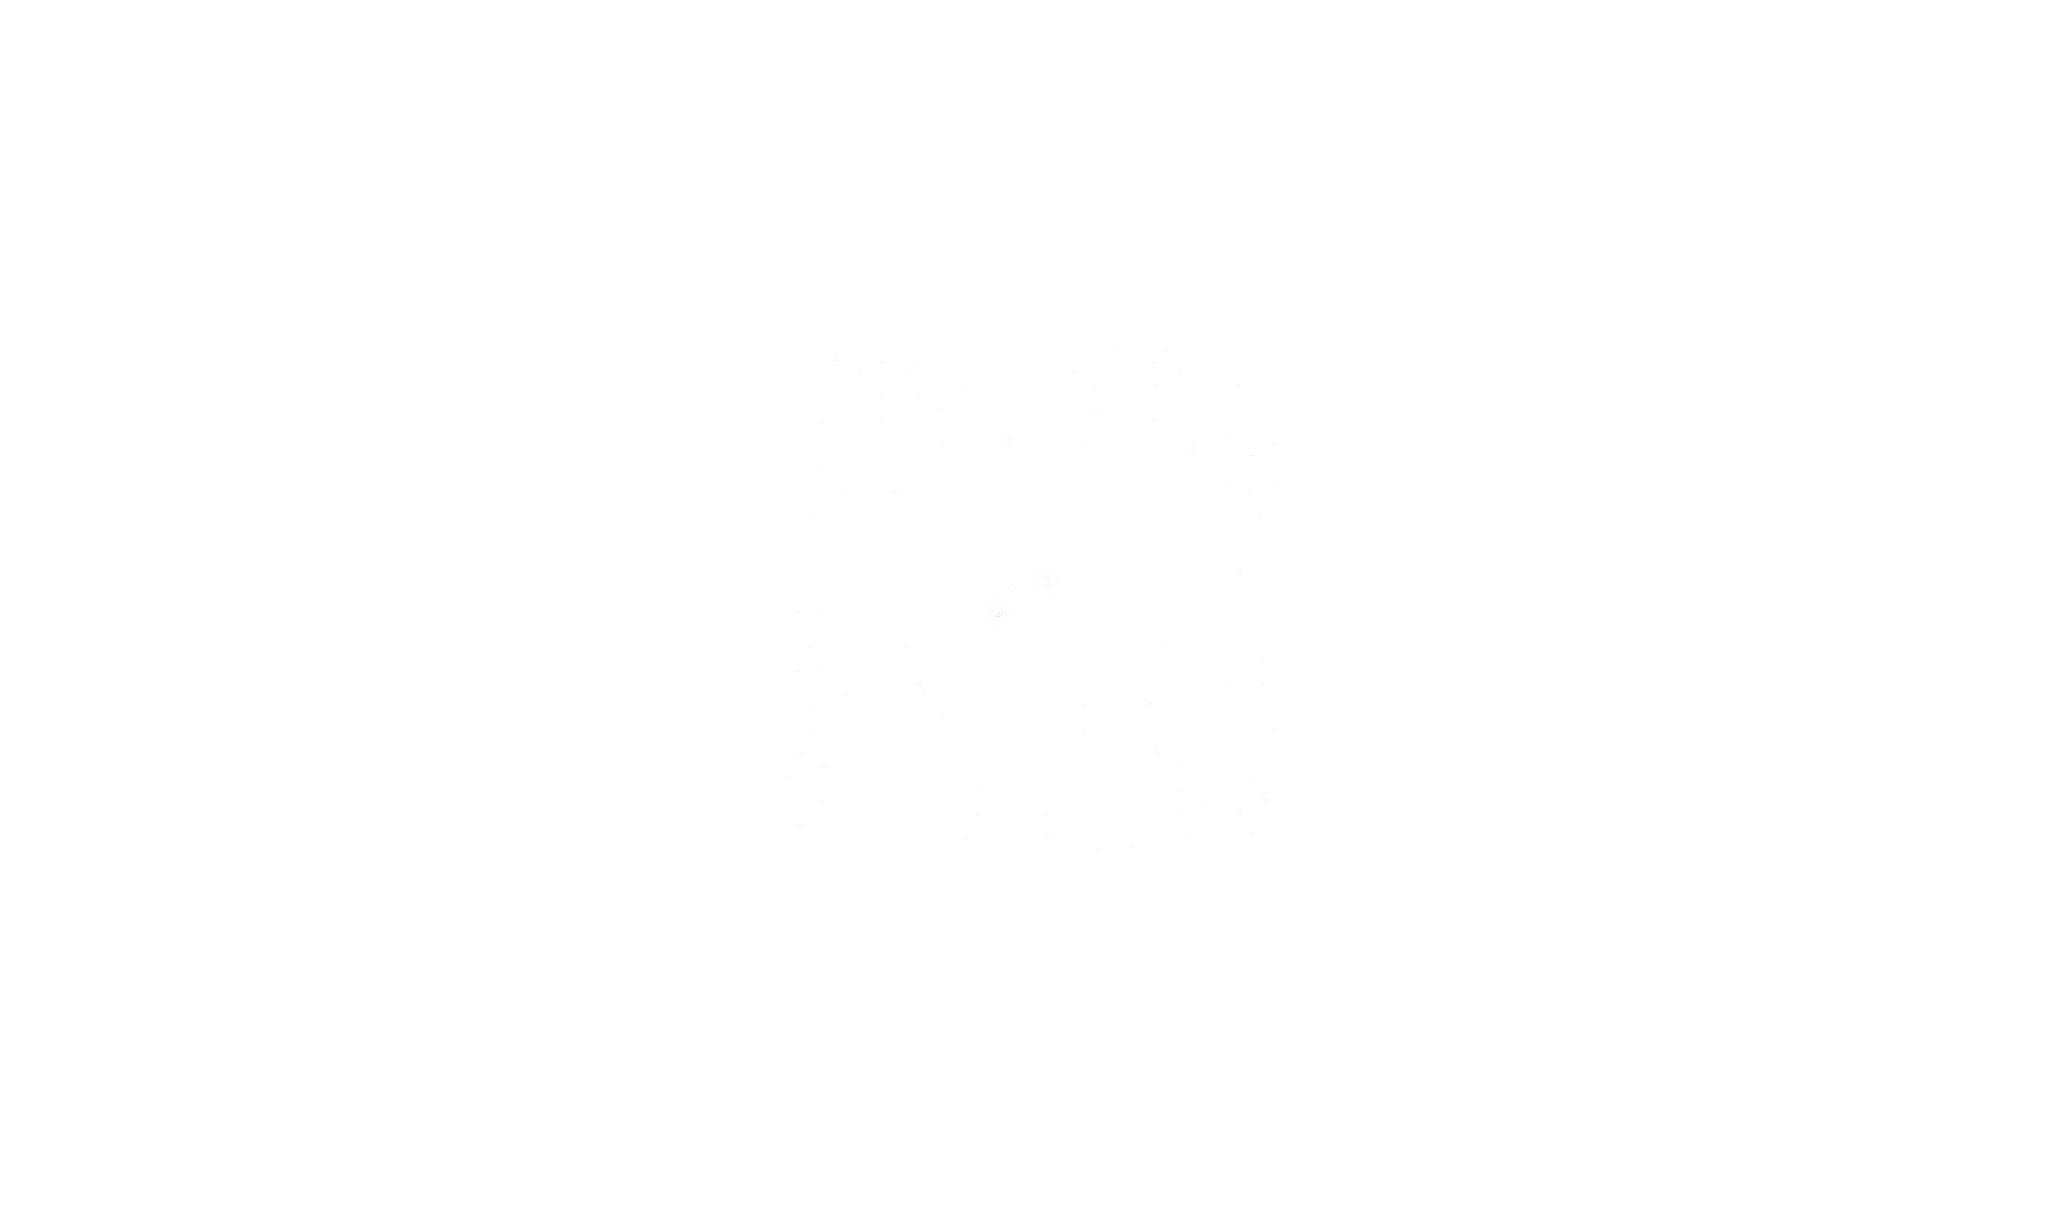

In [69]:
dot # create graph - this may take a while if graph is large

In [70]:
#Show Graph in lokal jupyter-lab
dot.render(format='svg', view=True)

'Digraph.gv.svg'

## 3.2 Grafische Darstellung mittels neo4j

Ein neo4j-Graph soll erstellt werden

In [16]:
from py2neo import Graph, Node, Relationship

In [17]:
#Change theese to use other database
neo4j_url="ADD_NEO4J_bolt_URL"
neo4j_pwd="PASSWORD"
neo4j_user="USERNAME"

In [18]:
#neo4j (Port) needs to be reachable - in case of Porblems check Firewall
graph = Graph(neo4j_url, auth=(neo4j_user, neo4j_pwd))
#graph.delete_all() # uncomment, if graph should be redone

In [19]:
# for large datasets this functions takes a while
# could be optimized
def create_neo4j(dataframe,gericht:str):
    for row in dataframe.itertuples():
        # Create a Node for every decision
        graph.run('''MERGE (a:'''+gericht+'''_Entscheidung {GZ: "'''+dataframe.loc[row.Index, 'case_number']+'''"})''')
        
        if (dataframe.loc[row.Index, 'OGH_citings']):
            for citing in dataframe.loc[row.Index, 'OGH_citings']:
                #print("citing")
                query='''
   MERGE (a:'''+gericht+'''_Entscheidung {GZ: "'''+dataframe.loc[row.Index, 'case_number']+'''"})
   MERGE (b:OGH_Entscheidung {GZ: "'''+citing+'''"})
   MERGE (a)-[:'''+gericht+'''_ZITIERT_OGH]->(b)
'''
                #print(query)
                graph.run(query)
        
        if (dataframe.loc[row.Index, 'VwGH_citings']):
            for citing in dataframe.loc[row.Index, 'VwGH_citings']:
                #print("citing")
                query='''
   MERGE (a:'''+gericht+'''_Entscheidung {GZ: "'''+dataframe.loc[row.Index, 'case_number']+'''"})
   MERGE (b:VwGH_Entscheidung {GZ: "'''+citing+'''"})
   MERGE (a)-[:'''+gericht+'''_ZITIERT_VwGH]->(b)
'''
                #print(query)
                graph.run(query)
        
        if (dataframe.loc[row.Index, 'VwGH_Slg_citings']):
            for citing in dataframe.loc[row.Index, 'VwGH_Slg_citings']:
                #print("citing")
                query='''
   MERGE (a:'''+gericht+'''_Entscheidung {GZ: "'''+dataframe.loc[row.Index, 'case_number']+'''"})
   MERGE (b:VwGH_Entscheidung {Slg: "'''+citing+'''"})
   MERGE (a)-[:'''+gericht+'''_ZITIERT_VwGH]->(b)
'''
                #print(query)
                graph.run(query)
        
        
        if (dataframe.loc[row.Index, 'VfGH_citings']):
            for citing in dataframe.loc[row.Index, 'VfGH_citings']:
                #print("citing")
                query='''
   MERGE (a:'''+gericht+'''_Entscheidung {GZ: "'''+dataframe.loc[row.Index, 'case_number']+'''"})
   MERGE (b:VfGH_Entscheidung {GZ: "'''+citing+'''"})
   MERGE (a)-[:'''+gericht+'''_ZITIERT_VfGH]->(b)
'''
                #print(query)
                graph.run(query)
                
        if (dataframe.loc[row.Index, 'VfGH_Slg_citings']):
            for citing in dataframe.loc[row.Index, 'VfGH_Slg_citings']:
                #print("citing")
                query='''
   MERGE (a:'''+gericht+'''_Entscheidung {GZ: "'''+dataframe.loc[row.Index, 'case_number']+'''"})
   MERGE (b:VfGH_Entscheidung {Slg: "'''+citing+'''"})
   MERGE (a)-[:'''+gericht+'''_ZITIERT_VfGH]->(b)
'''
                #print(query)
                graph.run(query)

In [20]:
for organ, dataframe in dataframes.items():
    create_neo4j(dataframe,organ)

In [21]:
query="CALL gds.graph.drop('pagerank')" # to make sure we make a new pagerank, lets drop any oldones
graph.run(query) # Error is normal if graph was not created before

graphName,database,memoryUsage,sizeInBytes,nodeProjection,relationshipProjection,nodeQuery,relationshipQuery,nodeCount,relationshipCount,nodeFilter,relationshipFilter,density,creationTime,modificationTime,schema
pagerank,neo4j,,-1,null,null,MATCH (n) RETURN id(n) AS id,"MATCH (n)-[r:VfGH_ZITIERT_VwGH|VfGH_ZITIERT_OGH|VfGH_ZITIERT_VfGH|OGH_ZITIERT_VwGH|OGH_ZITIERT_OGH|OGH_ZITIERT_VfGH|VwGH_ZITIERT_VwGH|VwGH_ZITIERT_OGH|VwGH_ZITIERT_VfGH]->(m) RETURN id(n) AS source, id(m) AS target",402,486,null,null,0.003014850932370566,datetime('2022-01-06T06:59:40.480224000+00:00'),datetime('2022-01-06T06:59:44.998374000+00:00'),"{relationships: {__ALL__: {}}, nodes: {__ALL__: {}}}"


In [22]:
query="CALL gds.graph.create.cypher('pagerank','MATCH (n) RETURN id(n) AS id','MATCH (n)-[r:VfGH_ZITIERT_VwGH|VfGH_ZITIERT_OGH|VfGH_ZITIERT_VfGH|OGH_ZITIERT_VwGH|OGH_ZITIERT_OGH|OGH_ZITIERT_VfGH|VwGH_ZITIERT_VwGH|VwGH_ZITIERT_OGH|VwGH_ZITIERT_VfGH]->(m) RETURN id(n) AS source, id(m) AS target',{validateRelationships:false})"
graph.run(query)

nodeQuery,relationshipQuery,graphName,nodeCount,relationshipCount,createMillis
MATCH (n) RETURN id(n) AS id,"MATCH (n)-[r:VfGH_ZITIERT_VwGH|VfGH_ZITIERT_OGH|VfGH_ZITIERT_VfGH|OGH_ZITIERT_VwGH|OGH_ZITIERT_OGH|OGH_ZITIERT_VfGH|VwGH_ZITIERT_VwGH|VwGH_ZITIERT_OGH|VwGH_ZITIERT_VfGH]->(m) RETURN id(n) AS source, id(m) AS target",pagerank,402,486,200


In [23]:
query = "CALL gds.pageRank.stream('pagerank') YIELD nodeId, score RETURN nodeId, gds.util.asNode(nodeId).GZ AS Entscheidung, score ORDER BY score DESC"


result_df = graph.query(query).to_data_frame()
print(result_df.head(11))

    nodeId     Entscheidung     score
0      314         G79/2013  1.537127
1      319        V68/2013   1.537127
2      216  Ro 2015/17/0028  0.502424
3      159       8Ob372/97g  0.475499
4      146        10Ob3/07z  0.372629
5      287       G315/2015   0.371925
6      286        G201/2014  0.350157
7      214  Ra 2016/17/0259  0.346121
8      238  Ra 2016/22/0092  0.341908
9      158        2Ob55/99y  0.337246
10      95       5Ob305/00i  0.317572


In [69]:
#Save Graph to local file
query="""CALL apoc.export.cypher.all(null, {
    streamStatements: true
})
YIELD nodes, relationships, properties, cypherStatements
RETURN nodes, relationships, properties, cypherStatements;"""
cypher=graph.run(query).to_data_frame()
with open('graph.cypher', 'w') as file:
    file.write(cypher.iat[0,3])

In [26]:
#Load Graph from local file
with open('graph.cypher', 'r') as cypher_file:
    cypher_query = cypher_file.read()

query="""CALL apoc.cypher.runMany('"""+cypher_query+"""',{})""" 
graph.run(query)

row,result
-1,"{constraintsRemoved: 0, indexesRemoved: 0, nodesCreated: 0, rows: 0, propertiesSet: 0, labelsRemoved: 0, relationshipsDeleted: 0, constraintsAdded: 0, nodesDeleted: 0, indexesAdded: 0, labelsAdded: 0, relationshipsCreated: 0, time: 0}"
-1,"{constraintsRemoved: 0, indexesRemoved: 0, nodesCreated: 20, rows: 0, propertiesSet: 40, labelsRemoved: 0, relationshipsDeleted: 0, constraintsAdded: 0, nodesDeleted: 0, indexesAdded: 0, labelsAdded: 40, relationshipsCreated: 0, time: 0}"
-1,"{constraintsRemoved: 0, indexesRemoved: 0, nodesCreated: 20, rows: 0, propertiesSet: 40, labelsRemoved: 0, relationshipsDeleted: 0, constraintsAdded: 0, nodesDeleted: 0, indexesAdded: 0, labelsAdded: 40, relationshipsCreated: 0, time: 0}"


In [27]:
#Testcode to check if import worked
print(len(graph.nodes))
print(len(graph.relationships))

2810
2636


## 3.3 Grafische Darstellung mittels Webseite (viz.js)

Um den Grafen in einer Webseite darzustellen, siehe: https://github.com/nicolewhite/neo4j-jupyter

# 4 (Statistische) Auswertung
Welche Behörde zitiert sich selbst am meisten?
Wie häufig zitieren sich Behörden untereinander?

In [47]:
def count_citings(dataframe):
    for cited_organ in ["OGH","VfGH","VfGH_Slg","VwGH","VwGH_Slg"]:
        dataframe['num_'+cited_organ+'_citings']=dataframe.apply(lambda x: len(x[cited_organ+'_citings']), axis=1)

In [48]:
for organ_dataframe in dataframes.values():
    count_citings(organ_dataframe)


In [49]:
for cited_organ in ["OGH","VwGH","VfGH","VwGH_Slg","VfGH_Slg"]:
    for organ, organ_dataframe in dataframes.items():
        
        print(organ+" zitiert "+str(cited_organ),organ_dataframe['num_'+cited_organ+'_citings'].sum())
    print("\n\n")

OGH zitiert OGH 785
VwGH zitiert OGH 10
VfGH zitiert OGH 35



OGH zitiert VwGH 2
VwGH zitiert VwGH 979
VfGH zitiert VwGH 211



OGH zitiert VfGH 3
VwGH zitiert VfGH 66
VfGH zitiert VfGH 1190



OGH zitiert VwGH_Slg 0
VwGH zitiert VwGH_Slg 2
VfGH zitiert VwGH_Slg 29



OGH zitiert VfGH_Slg 0
VwGH zitiert VfGH_Slg 10
VfGH zitiert VfGH_Slg 2177





In [50]:
def make_autopct(data):
    def my_autopct(pct):
        total = sum(data)
        val = int(round(pct*total/100.0))
        return '{p:.1f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

Number of decisions in dataset


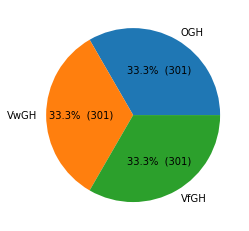

In [51]:
# number of decisions in dataset (to put the following plots into perspective)

# Creating dataset
label = ['OGH', 'VwGH', "VfGH"]
data = [len(dataframes['OGH'].index),len(dataframes['VwGH'].index),len(dataframes['VfGH'].index)]

# Creating plot
fig = plt.figure()
#plt.pie(data, labels = label, autopct='%.1f%%')
plt.pie(data, labels = label, autopct=make_autopct(data))
# show plot
print("Number of decisions in dataset")
plt.show()



OGH citing distribution:


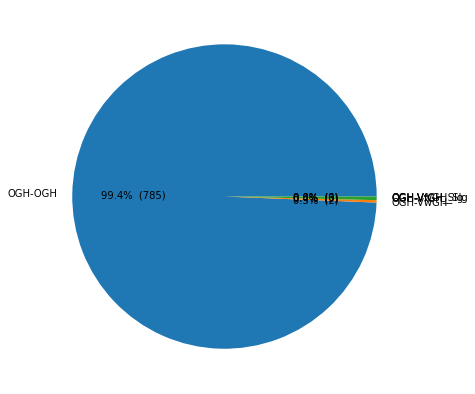

VwGH citing distribution:


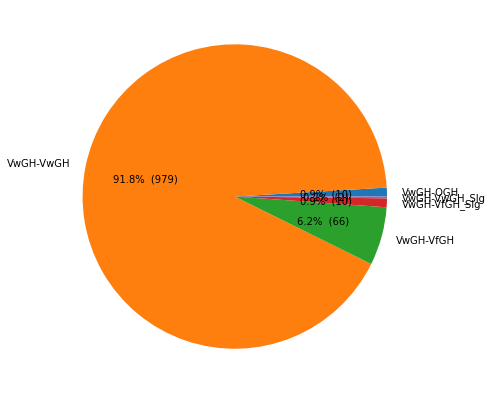

VfGH citing distribution:


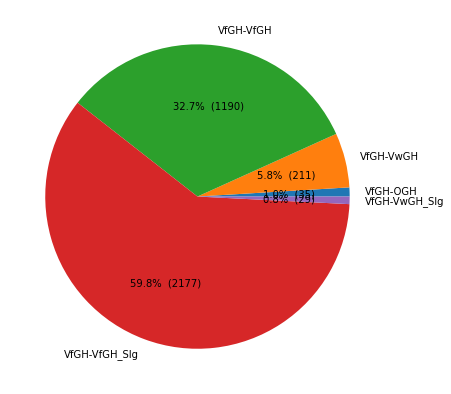

In [52]:
#plot citing distribution


for organ, organ_dataframe in dataframes.items():
    label = [organ+'-OGH', organ+'-VwGH', organ+"-VfGH", organ+"-VfGH_Slg",organ+"-VwGH_Slg"]
    data = [organ_dataframe['num_OGH_citings'].sum(),organ_dataframe['num_VwGH_citings'].sum(),organ_dataframe['num_VfGH_citings'].sum(),organ_dataframe['num_VfGH_Slg_citings'].sum(),organ_dataframe['num_VwGH_Slg_citings'].sum()]
    # Creating plot
    fig = plt.figure(figsize =(10, 7))
    plt.pie(data, labels = label, autopct=make_autopct(data))

    # show plot
    print(organ+" citing distribution:")
    plt.show()


mean OGH citing distribution:


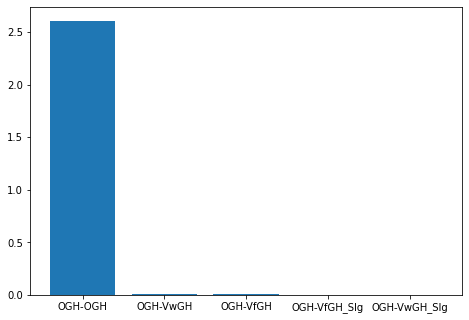

mean VwGH citing distribution:


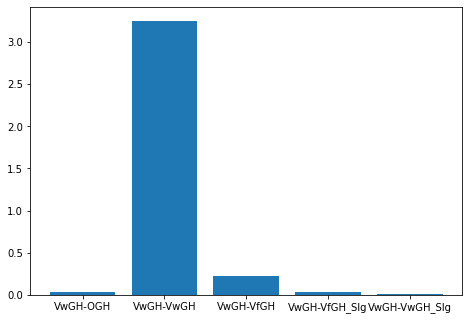

mean VfGH citing distribution:


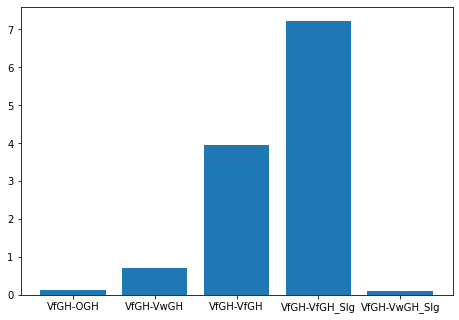

In [53]:
#plot mean citing distribution
for organ, organ_dataframe in dataframes.items():
    label = [organ+'-OGH', organ+'-VwGH', organ+"-VfGH", organ+"-VfGH_Slg",organ+"-VwGH_Slg"]
    data = [organ_dataframe['num_OGH_citings'].mean(),organ_dataframe['num_VwGH_citings'].mean(),organ_dataframe['num_VfGH_citings'].mean(),organ_dataframe['num_VfGH_Slg_citings'].mean(),organ_dataframe['num_VwGH_Slg_citings'].mean()]
    # Creating plot
    fig = plt.figure()
    ax = fig.add_axes([1,1,1,1])
    ax.bar(label,data)
    #plt.pie(data, labels = label, autopct=make_autopct(data))

    # show plot
    print("mean "+organ+" citing distribution:")
    plt.show()

In [54]:
def count_unique_citings(dataframe,organ:str):
    if organ not in ["OGH","VfGH","VwGH","VfGH_Slg","VwGH_Slg"]:
        raise ValueError('Organ unknow')
    unique_citings = {}
    for row in dataframe.itertuples():
        if (dataframe.loc[row.Index, organ+'_citings']):
            for citing in dataframe.loc[row.Index, organ+'_citings']:
                if citing in unique_citings.keys():
                    unique_citings[citing] += 1
                else:
                    unique_citings[citing] = 1
   
    unique_citings={k:v for k, v in sorted(unique_citings.items(), key=lambda item: item[1], reverse=True)} # Sort to reveal most cited
    return unique_citings

In [55]:
num_top_citings=3 # variable to quickly change output



    
unique_citings_OGH=["OGH->OGH:",dict(itertools.islice(count_unique_citings(dataframes['OGH'],"OGH").items(), num_top_citings)),"OGH->VwGH:",dict(itertools.islice(count_unique_citings(dataframes['OGH'],"VwGH").items(), num_top_citings)),"OGH->VfGH:",dict(itertools.islice(count_unique_citings(dataframes['OGH'],"VfGH").items(), num_top_citings)),"OGH->VfGH_Slg:",dict(itertools.islice(count_unique_citings(dataframes['OGH'],"VfGH_Slg").items(), num_top_citings)),"OGH->VwGH_Slg:",dict(itertools.islice(count_unique_citings(dataframes['OGH'],"VwGH_Slg").items(), num_top_citings))]
unique_citings_VwGH=["VwGH->OGH:",dict(itertools.islice(count_unique_citings(dataframes['VwGH'],"OGH").items(), num_top_citings)),"VwGH->VwGH:",dict(itertools.islice(count_unique_citings(dataframes['VwGH'],"VwGH").items(), num_top_citings)),"VwGH->VfGH:",dict(itertools.islice(count_unique_citings(dataframes['VwGH'],"VfGH").items(), num_top_citings)),"VwGH->VfGH_Slg:",dict(itertools.islice(count_unique_citings(dataframes['VwGH'],"VfGH_Slg").items(), num_top_citings)),"VwGH->VwGH_Slg:",dict(itertools.islice(count_unique_citings(dataframes['VwGH'],"VwGH_Slg").items(), num_top_citings))]
unique_citings_VfGH=["VfGH->OGH:",dict(itertools.islice(count_unique_citings(dataframes['VfGH'],"OGH").items(), num_top_citings)),"VfGH->VwGH:",dict(itertools.islice(count_unique_citings(dataframes['VfGH'],"VwGH").items(), num_top_citings)),"VfGH->VfGH:",dict(itertools.islice(count_unique_citings(dataframes['VfGH'],"VfGH").items(), num_top_citings)),"VfGH->VfGH_Slg:",dict(itertools.islice(count_unique_citings(dataframes['VfGH'],"VfGH_Slg").items(), num_top_citings)),"VfGH->VwGH_Slg:",dict(itertools.islice(count_unique_citings(dataframes['VfGH'],"VwGH_Slg").items(), num_top_citings))]



print("OGH-top-citings",unique_citings_OGH)

print("VwGH-top-citings",unique_citings_VwGH)

print("VfGH-top-citings",unique_citings_VfGH)



print("--------------------------------------------")
df_all_combined= pd.concat([dataframes['OGH'], dataframes['VwGH'], dataframes['VfGH']], ignore_index=True)
unique_citings_combined={}
for organ in dataframes:
    unique_citings_combined[organ] = dict(itertools.islice(count_unique_citings(df_all_combined,organ).items(), num_top_citings))
    print(organ + " overall top citings",(unique_citings_combined[organ]))

    



OGH-top-citings ['OGH->OGH:', {'4Ob150/19s': 22, '8Ob80/19a': 10, '1Ob171/19g': 10}, 'OGH->VwGH:', {'Ra 2017/20/0290': 1, 'Ra 2015/09/0137': 1}, 'OGH->VfGH:', {'A 2020/2711': 1, 'G314/2015': 1, 'G 267/2018': 1}, 'OGH->VfGH_Slg:', {}, 'OGH->VwGH_Slg:', {}]
VwGH-top-citings ['VwGH->OGH:', {'8Ob92/09a': 1, '5Ob149/09m': 1, '9ObA195/05z': 1}, 'VwGH->VwGH:', {'Ra 2018/17/0048': 7, 'Ra 2019/14/0160': 6, 'Ra 2019/14/0153': 5}, 'VwGH->VfGH:', {'E 885/2018': 2, 'E 2458/2016': 1, 'E 2738/2017': 1}, 'VwGH->VfGH_Slg:', {'19540': 1, '11.574': 1, '16.395': 1}, 'VwGH->VwGH_Slg:', {'VwSlg 10140 A/1980': 1, 'VwSlg. 9.315 A/1977': 1}]
VfGH-top-citings ['VfGH->OGH:', {'4Ob213/11v': 1, '10Ob19/15i': 1, '4Ob287/04s': 1}, 'VfGH->VwGH:', {'Ra 2018/18/0533': 14, 'Ra 2019/14/0160': 8, 'Ra 2019/18/0278': 8}, 'VfGH->VfGH:', {'E3369/2019': 26, 'E2692/2019': 25, 'E1796/2016': 21}, 'VfGH->VfGH_Slg:', {'14.650': 118, '13.836': 118, '16.080': 118}, 'VfGH->VwGH_Slg:', {'VwSlg 17.505 A/2008': 1, 'VwSlg 17.029 A/2006': 

# (Nutzung des RIS-API-wrapers (https://github.com/PhilippTh/ris-API-wrapper) für leichteren Zugang zu Entscheidungen)

In [22]:
# copy code here to make ris-API-wrapper work